# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook 7 - Building an ensemble and testing

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In this workbook we're choosing the right ML algorithms based on cross validation, building an ensemple and testing it.

In [10]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..')
sys.path.append(path_to_project)

In [11]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import pickle
import warnings
warnings.filterwarnings('ignore')

In [12]:
import WQUcapstoneCode.ml.ml as wqu
#from WQUcapstoneCode.ml.ml import cv_with_custom_score, train_valid_test_split, get_pyfolio_simple_tear_sheet

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [14]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [15]:
tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']

We are here to look at the data input for each currency pair to ensure same period is adopted in the analysis across currency pair. We take the overlapping time period for all currency pairs, which are the maximum of each of the currency minimal time observed and the minimum of each of the currency maximum time observed.

In [16]:
min_period = dt.datetime(1999, 1, 1, 0, 0) #initialize the smallest min_period
max_period = dt.datetime.now() #initalize the largest min_period for comparison

for ticker in tickers:
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)

    if max(data.index) < max_period:
        max_period = max(data.index)
        
    if min(data.index) > min_period:
        min_period = min(data.index)

In [17]:
# Checking the maximun period to be used.
max_period

Timestamp('2020-06-17 23:00:00')

In [18]:
# Checking the minimum period to be used.
min_period

Timestamp('2015-10-06 13:00:00')

Below we calculate feature inportance based on Random Forest, and then teach a number of ML algorythms using different sets of features.

In [19]:
RANDOM_STATE = 1

# Training set variable initiation
# ----------------------------------------------------------
score_dict = {}
rtn_dict = {}
sharp_dict = {}
n_splits = 5 # for cross validation

models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   

# Validation set variable initiation
# ----------------------------------------------------------
rtns_valid =  {}
sharp_valid =  {}
vol_valid= {}

# Testing set variable initiation
# ----------------------------------------------------------
rtns_test =  {}
sharp_test =  {}
vol_test= {}
      
# Loop for each currency pair
# ----------------------------------------------------------
for ticker in tickers:

    # To populate current time for running the code
    d = dt.datetime.now().strftime('%I:%M%p')
    print(f'{d}: Cross-validating on {ticker}')
    
     # Data input 
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
    
    # Standardize data period across all currency pair for easy comparison
    data = data.loc[min_period:max_period] # Sergey: not necessary - the sata is already within this interval anyway
    
    # splitting the data into training, validation and testing set.
    X_train, Y_train, target_rtns_train \
    , X_valid, Y_valid, target_rtns_valid \
    , X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')
    
    # here we use all training set to calculate feature importances, which is a cheat because later part of cross validated set becomes validation set. 
    # However, it was found that features are relatively stable across subsets. 
    # In any case, the result will be tested using validation set
    all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train, models['Tuned RF'])
    
    features = {'all_feature_cols':all_feature_cols, 
                'ex_frdiff_cols':ex_frdiff_cols,
                'frdiff_cols':frdiff_cols,
                'top_feat_RF': top_feat
               }
    
    # Define k-fold cross validation here
    cv = KFold(n_splits=n_splits, shuffle=False)
    
    # Training set
    score_dict[ticker] = {}
    sharp_dict[ticker] = {}
    rtn_dict[ticker] = {}
    
    # Validation set
    rtns_valid[ticker] =  {}
    sharp_valid[ticker] =  {}
    vol_valid[ticker] = {}
    
    # Test set
    rtns_test[ticker] =  {}
    sharp_test[ticker] =  {}
    vol_test[ticker] = {}
    
    for n,cols in features.items():
        
        # Testing set within a currency pair
        score_dict[ticker][n] = {}
        sharp_dict[ticker][n] = {}
        rtn_dict[ticker][n] = {}
        
        # Validation set within a currency pair
        rtns_valid[ticker][n] =  {}
        sharp_valid[ticker][n] =  {}
        vol_valid[ticker][n] = {}
                
        # Testing set within a currency pair
        rtns_test[ticker][n] =  {}
        sharp_test[ticker][n] =  {}
        vol_test[ticker][n] = {}
        
        for m,c in models.items():
            
            # Training and cross validating all algorithms
            n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')           
            r, sh = wqu.cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
            
            rtn_dict[ticker][n][m] = r
            score_dict[ticker][n][m] = np.mean(n_scores)
            sharp_dict[ticker][n][m] = sh
    
            # Validating set for all algorithms               
            rtn = c.fit(X_train[cols],Y_train).predict(X_valid[cols]) * target_rtns_valid
            days = np.busday_count(X_valid.index.min().date(),X_valid.index.max().date())
            
            rtns_valid[ticker][n][m] = np.sum(rtn) * 252 /days
            vol_valid[ticker][n][m] = np.std(rtn.groupby(rtn.index.date).sum())*np.sqrt(252)
            sharp_valid[ticker][n][m] = rtns_valid[ticker][n][m] / vol_valid[ticker][n][m]
            
            # Testing set for all algorithms
            # Here we retrain the model by using validation data as this is more recent data to out-sample data
            rtn = c.fit(X_valid[cols],Y_valid).predict(X_test[cols]) * target_rtns_test
            days = np.busday_count(X_test.index.min().date(),X_test.index.max().date())
            
            rtns_test[ticker][n][m] = np.sum(rtn) * 252 /days
            vol_test[ticker][n][m] = np.std(rtn.groupby(rtn.index.date).sum())*np.sqrt(252)
            sharp_test[ticker][n][m] = rtns_test[ticker][n][m] / vol_test[ticker][n][m]

03:40PM: Cross-validating on AUD/USD
03:44PM: Cross-validating on AUD/CAD
03:47PM: Cross-validating on AUD/JPY
03:50PM: Cross-validating on EUR/USD
03:53PM: Cross-validating on GBP/USD
03:56PM: Cross-validating on NZD/USD
03:59PM: Cross-validating on USD/CAD
04:02PM: Cross-validating on USD/JPY


Export data as pickle file as generation of the data takes ~10min to export the training, validation and testing results.

In [20]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, 'wb') as output_file:
    pickle.dump({'returns':rtn_dict, 'accuracy': score_dict, 'sharp': sharp_dict}, output_file)
    
pickle_path_valid = os.path.join(path_to_project, 'preprocessed_data', 'algos_valid.p')
with open(pickle_path_valid, 'wb') as output_file:
    pickle.dump({'returns':rtns_valid, 'vol': vol_valid, 'sharp': sharp_valid},output_file)
    
pickle_path_test = os.path.join(path_to_project, 'preprocessed_data', 'algos_test.p')
with open(pickle_path_test, 'wb') as output_file:
    pickle.dump({'returns':rtns_test, 'vol': vol_test, 'sharp': sharp_test}, output_file)

Load pickle data from archive.

In [8]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, "rb") as input_file:
    d = pickle.load(input_file)
    rtn_dict = d['returns']
    score_dict = d['accuracy']
    sharp_dict = d['sharp']
    
pickle_path_valid = os.path.join(path_to_project, 'preprocessed_data', 'algos_valid.p')
with open(pickle_path_valid, "rb") as input_file:
    d = pickle.load(input_file)
    rtns_valid = d['returns']
    vol_valid = d['vol']
    sharp_valid = d['sharp']
    
pickle_path_test = os.path.join(path_to_project, 'preprocessed_data', 'algos_test.p')
with open(pickle_path_test, "rb") as input_file:
    d = pickle.load(input_file)
    rtns_test = d['returns']
    vol_test = d['vol']
    sharp_test = d['sharp']

Now that we have score_dict, rtn_dict and sharp_dict objects, we can slice and dice them. We can either select the algorythms that perform better on average on all currency pairs, or we can use the best algorythms for a selected currency pair.
Please see below the average characteristics of algorythms.

# Traing set

### Accuracy map across currencies for training set

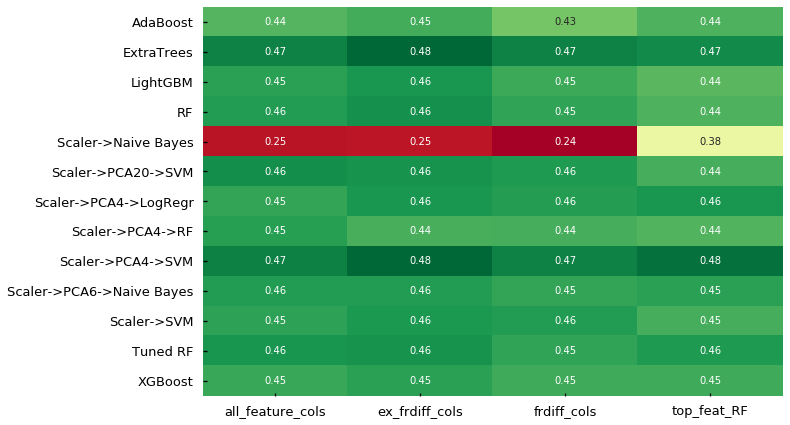

In [21]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in score_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For accuracy:
- From model perspective, it is observed that most models have a similar accurate score with the exception of Naive Bayes classification.
- From feature perspective, we do not see a significant difference for one feature set against the others.

### Returns across currency pairs for training set

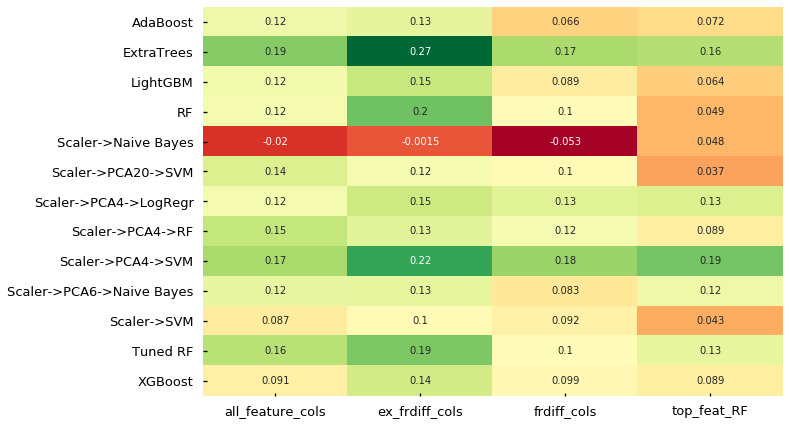

In [27]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in rtn_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For return across currency pairs:
- From model perspective, it is observed that SVM with 20 principal component vectors of the features, logistic regression with 4 principal component vectors of the features, Naive Bayes with 6 principal component vectors give better returns than other models.
- From feature perspective, it is observed that features undergoing fractional differencing and features pre-selected by the random forest model give a relatively better returns than other features

### Standard deivations across currency pairs for training set

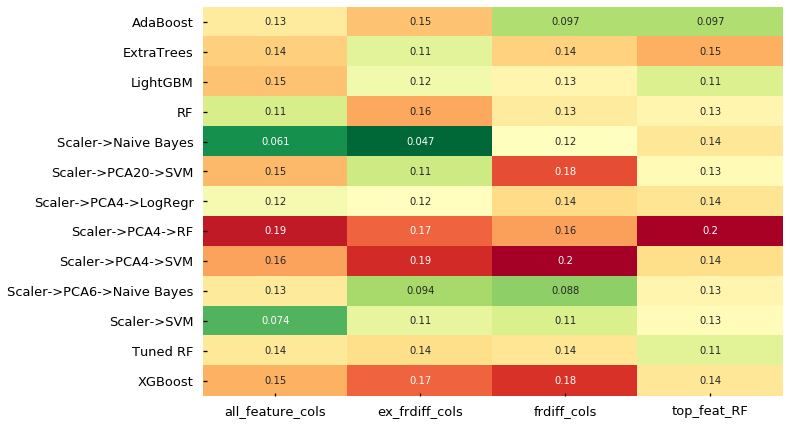

In [28]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in rtn_dict.items()]).groupby(level=0).std(),
            annot=True, cbar=False, cmap="RdYlGn_r")

For standard deviations across currency pairs:
- From model perspective, it is observed that Naive Bayes model gives minimal standard deviations, followed by Naive Bayes with features with 6 principal components. After that that would be random forest and logistic regression with features with 4 principal components.
- From feature perspective, it is observed that features undergoing fractional differencing and all features gives lower minimal standard deviations.

### Sharpe ratios across currencies for training set

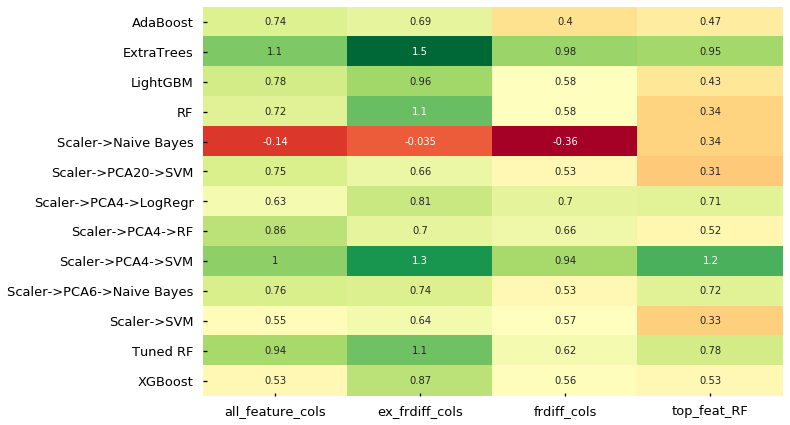

In [29]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in sharp_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For Sharpe Ratio across currency pairs:
- From model perspective, it is observed that ExtraTrees, SVM with 4 features principal components, tuned random forest work best, followed by logistic regression with 4 features principal components and Naive Bayes with 6 features principal components.
- From feature perspective, it is observed that feature not pre-processed by fractional differencing works best, followed by all features, features that applies to fractional differencing and last is the top feature pre-selected by random forest.

## Testing on validation sets

We now used the trained model to test the results on the validation sets.

### Returns across currency pairs for validation sets

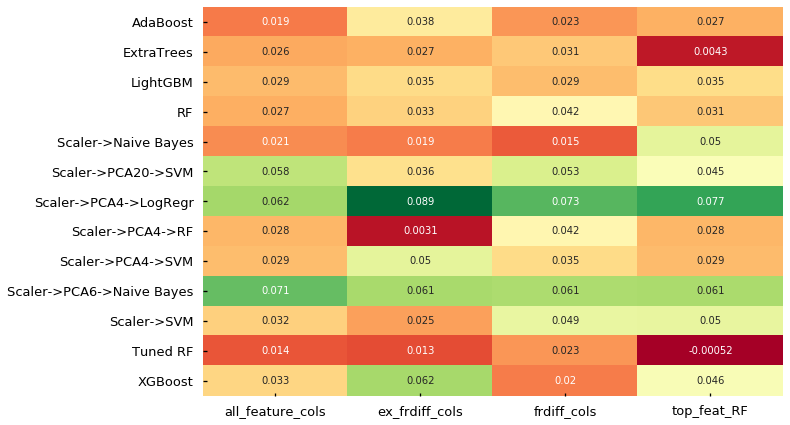

In [30]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in rtns_valid.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

From the above,
- From model perspective, it is observed that logistic regressions with 4 principal components and Naive Bayes with 6 principal components work better than other models.
- From feature perspective, it is observed that features pre-selected by random forest provides relatively better results than the other three sets.

### Volatilities across currency pairs for validation sets

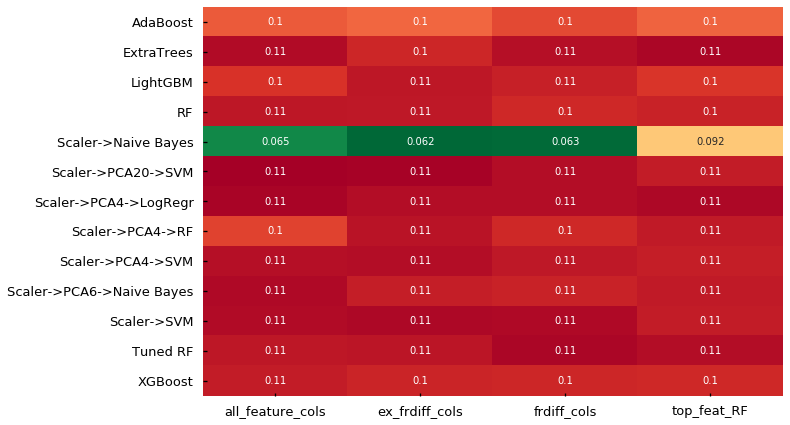

In [31]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in vol_valid.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn_r")

Similar to the findings in the training set, all model and features give similar volatilities with the exception that Naive Bayes give much lower volatility.

### Sharp ratios across currencies for validation set

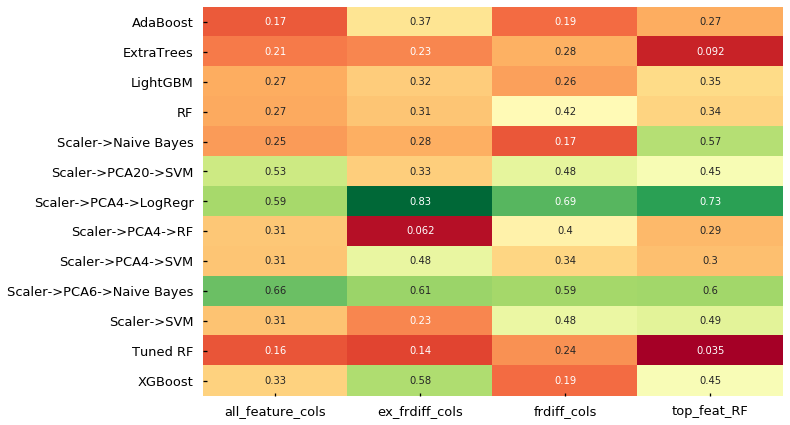

In [32]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in sharp_valid.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

From the above,
- From model perspective, it is observed that logistic regressions with 4 principal components and Naive Bayes with 6 principal components work better than other models.
- From feature perspective, it is observed that features pre-selected by random forest provides relatively better results than the other three sets.

Therefore we could look at logistic regressions with 4 principal components and Naive Bayes with 6 principal components from model, and also look at the features pre-processed by random forest.

## Testing on testing set

We now retrain the model using the validation set data to test the out-of-sample set

### Returns across currency pairs for testing set

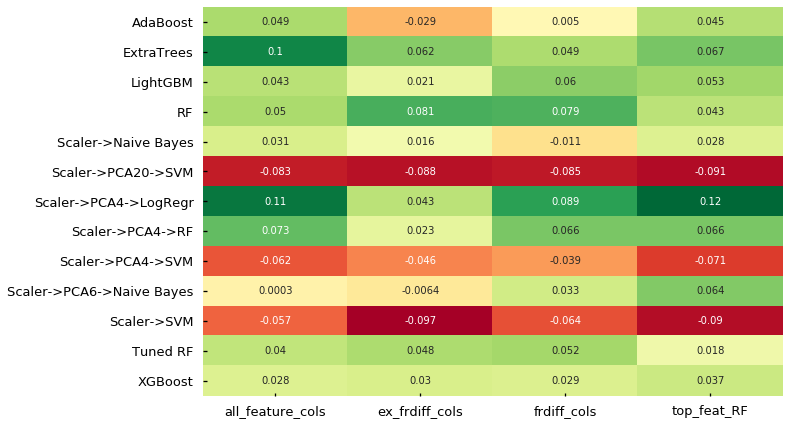

In [33]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in rtns_test.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For return accross currency pairs:
- From model perspective, it is observed that logistic regressions with 4 principal components still works better while Naive Bayes with 6 principal components does not work as good as the logistic regression. The performance of Naive Bayes with 6 principal components is fair. It is also noted other models which give worse predictive results perform better that the Naive Bayes model. This may be due to the update in the training data which is more time relevant.
- From feature perspective, it is observed that features pre-selected by the random forest model give broadly equal performance to all the features and outperforms features with and without fractional differencing.

### Volatilities across currency pairs for testing sets.

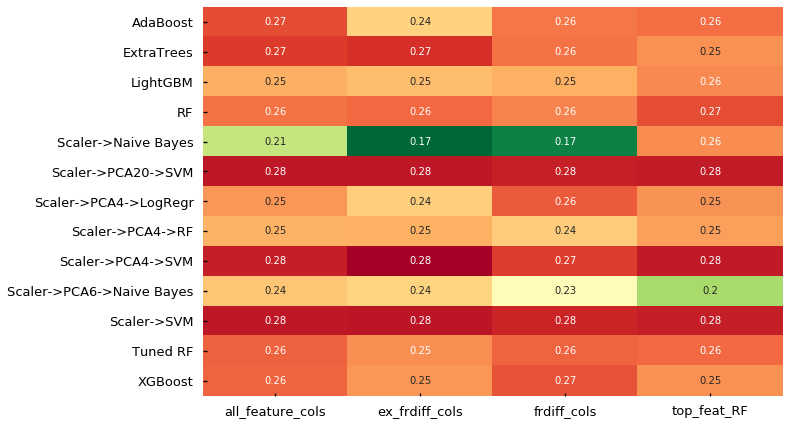

In [34]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in vol_test.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn_r")

For volatilities across currency pairs:
- From model perspective, it is observed that Naive Bayes with 6 principal components work slightly better than logistic regressions with 4 principal components. It is also noted that the most models give similar volatilities with the exception of Naive Bayes.
- From feature perspective, all the features give similar results.


### Sharpe ratios across currencies for testing set

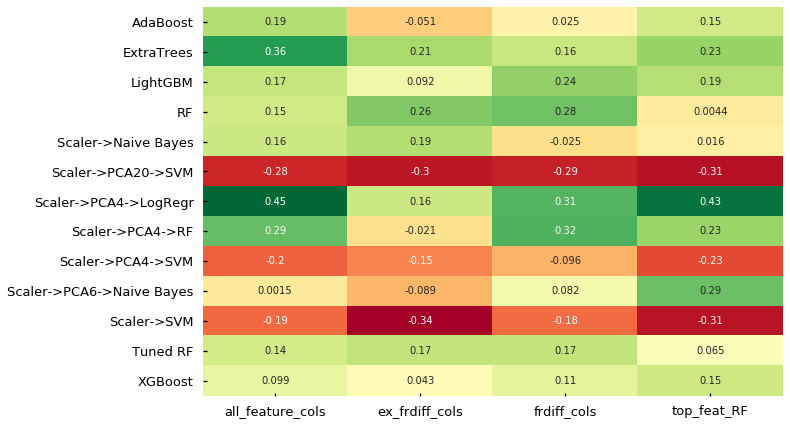

In [35]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in sharp_test.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For Sharpe Ratio across currency pairs:
- From model perspective, it is observed that logistic regressions with 4 principal components works best while Naive Bayes with 6 principal components work better than other algorithms.
- From feature perspective, it is observed that features pre-selected by random forest provides relatively better results while all features work best on average.
The above reinforced our observations in the validation during this out-of-sample testing.

---------------------------------------------

## Combining model and features

From the above, we would like to take the best out of the model and features, therefore we would like to explore for the following two models with each of the currency pair:
1. Logistic regressions with 4 principal components with features preprocessed by random forest.
2. Naive Bayes with 6 principal components with features preprocessed by random forest.

### AUD/USD

In [31]:
ticker = 'AUD/USD'

In [32]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [33]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2019-02-27
End date,2020-06-17
Total months,10
,Backtest
Annual return,37.6%
Cumulative returns,31.2%
Annual volatility,22.2%
Sharpe ratio,1.55
Calmar ratio,1.19
Stability,0.51
Max drawdown,-31.6%


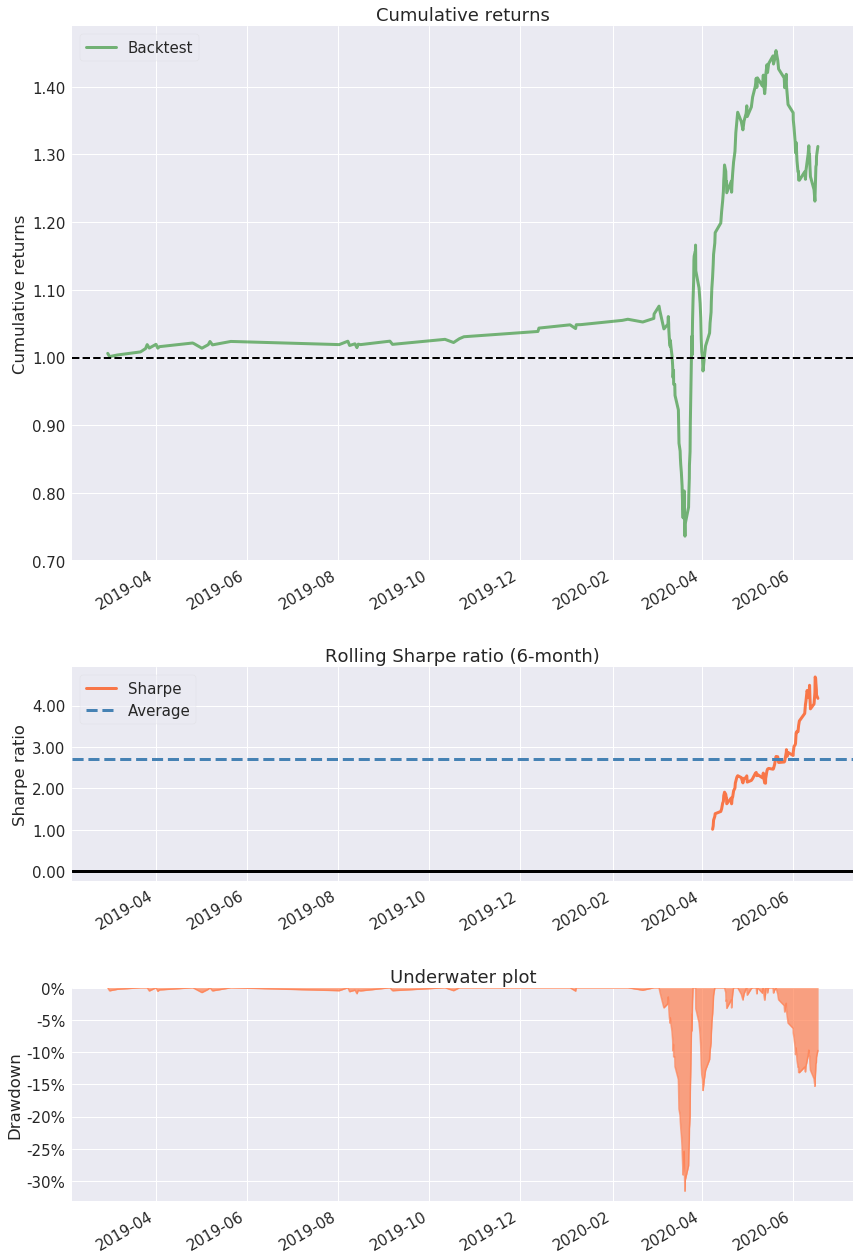

In [34]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2019-02-27
End date,2020-06-17
Total months,10
,Backtest
Annual return,44.1%
Cumulative returns,36.4%
Annual volatility,22.9%
Sharpe ratio,1.71
Calmar ratio,1.91
Stability,0.66
Max drawdown,-23.1%


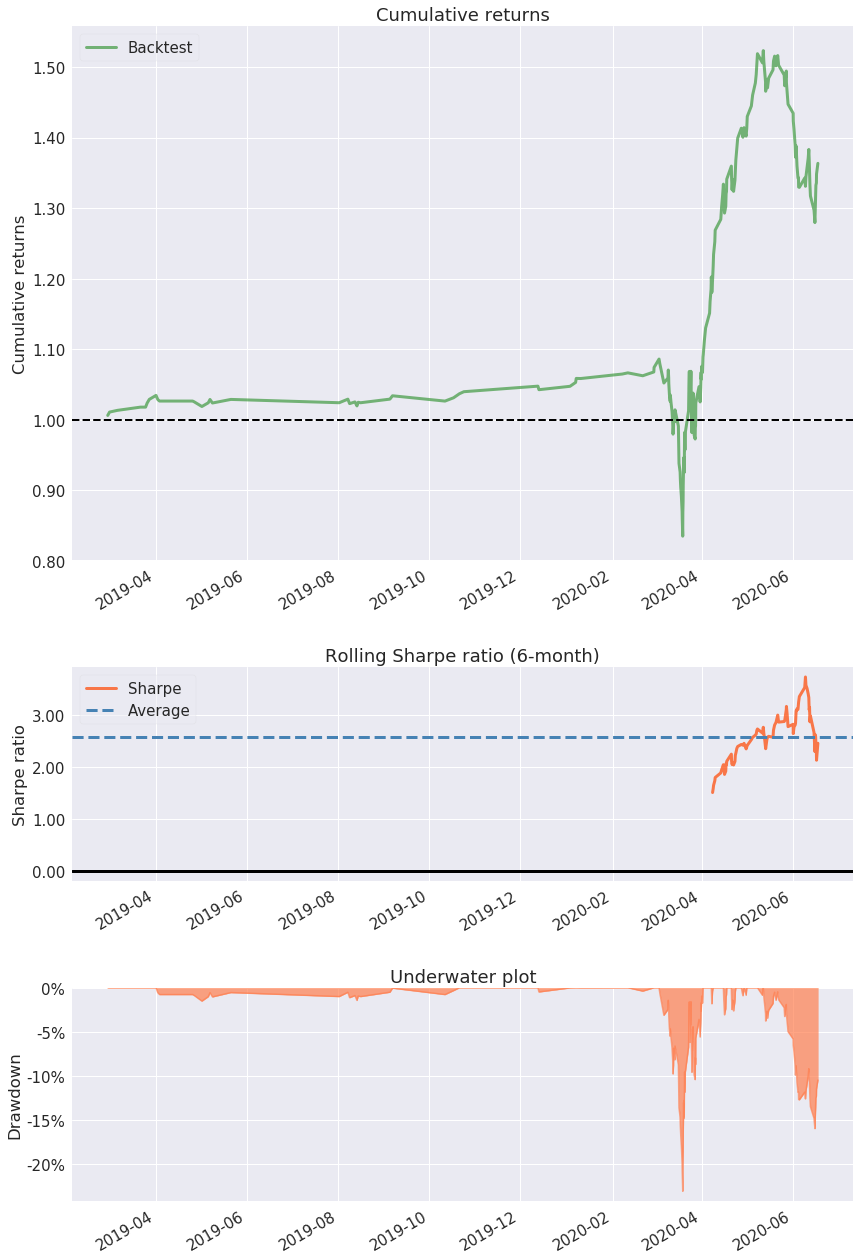

In [35]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### AUD/CAD

In [37]:
ticker = 'AUD/CAD'

In [38]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [39]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2019-05-29
End date,2020-06-17
Total months,10
,Backtest
Annual return,14.4%
Cumulative returns,12.4%
Annual volatility,16.9%
Sharpe ratio,0.88
Calmar ratio,0.60
Stability,0.04
Max drawdown,-24.1%


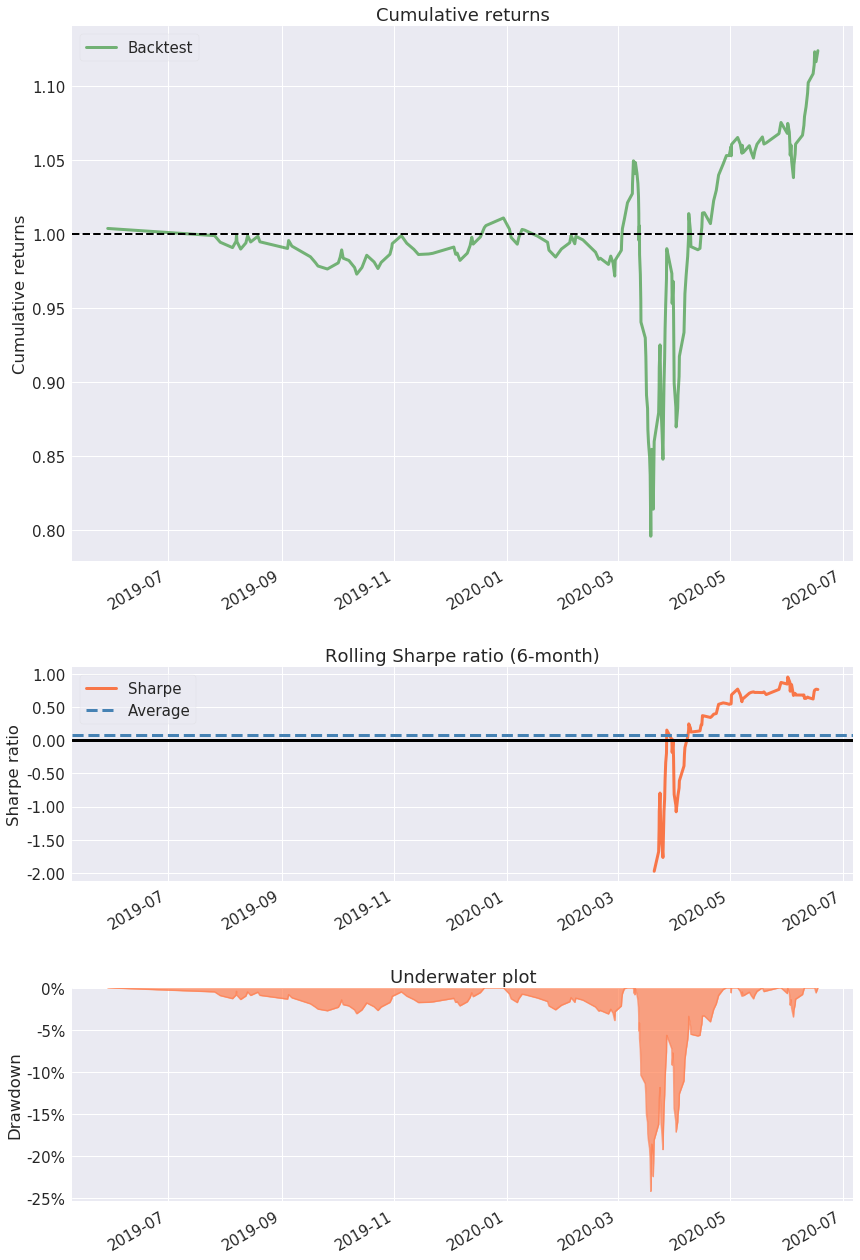

In [40]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2019-05-29
End date,2020-06-17
Total months,10
,Backtest
Annual return,-6.7%
Cumulative returns,-5.9%
Annual volatility,16.9%
Sharpe ratio,-0.33
Calmar ratio,-0.23
Stability,0.17
Max drawdown,-29.1%


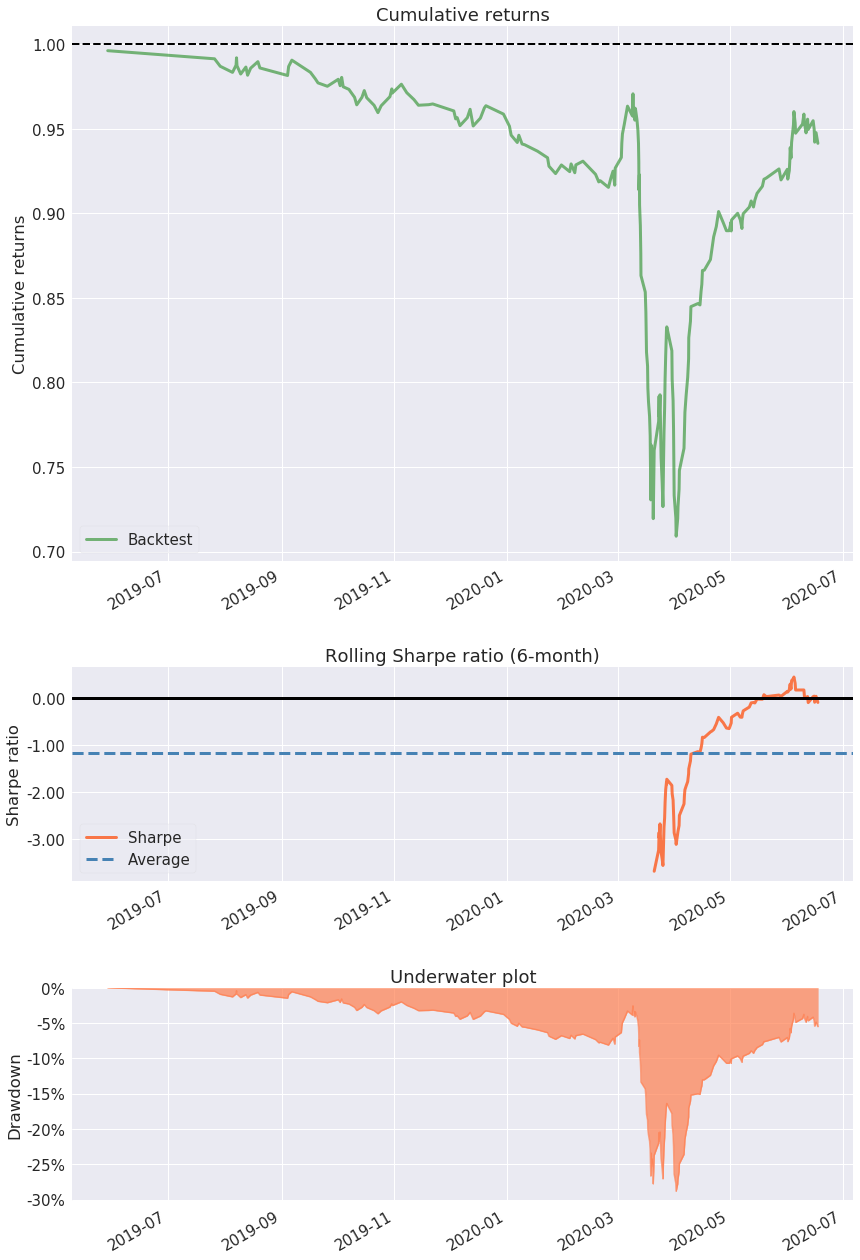

In [41]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### AUD/JPY

In [44]:
ticker = 'AUD/JPY'

In [45]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [46]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-6.0%
Cumulative returns,-5.2%
Annual volatility,18.1%
Sharpe ratio,-0.25
Calmar ratio,-0.15
Stability,0.37
Max drawdown,-39.5%


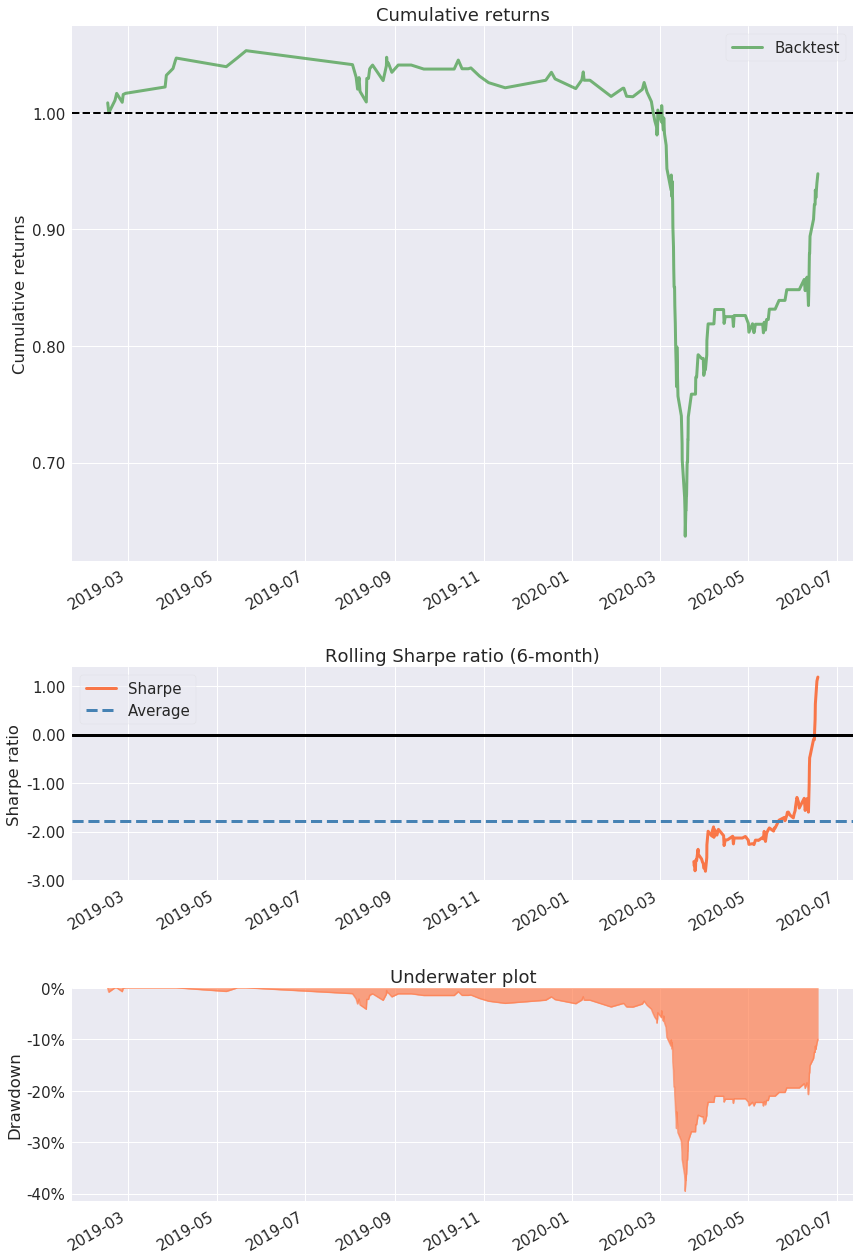

In [47]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-10.0%
Cumulative returns,-8.6%
Annual volatility,22.4%
Sharpe ratio,-0.36
Calmar ratio,-0.25
Stability,0.22
Max drawdown,-40.2%


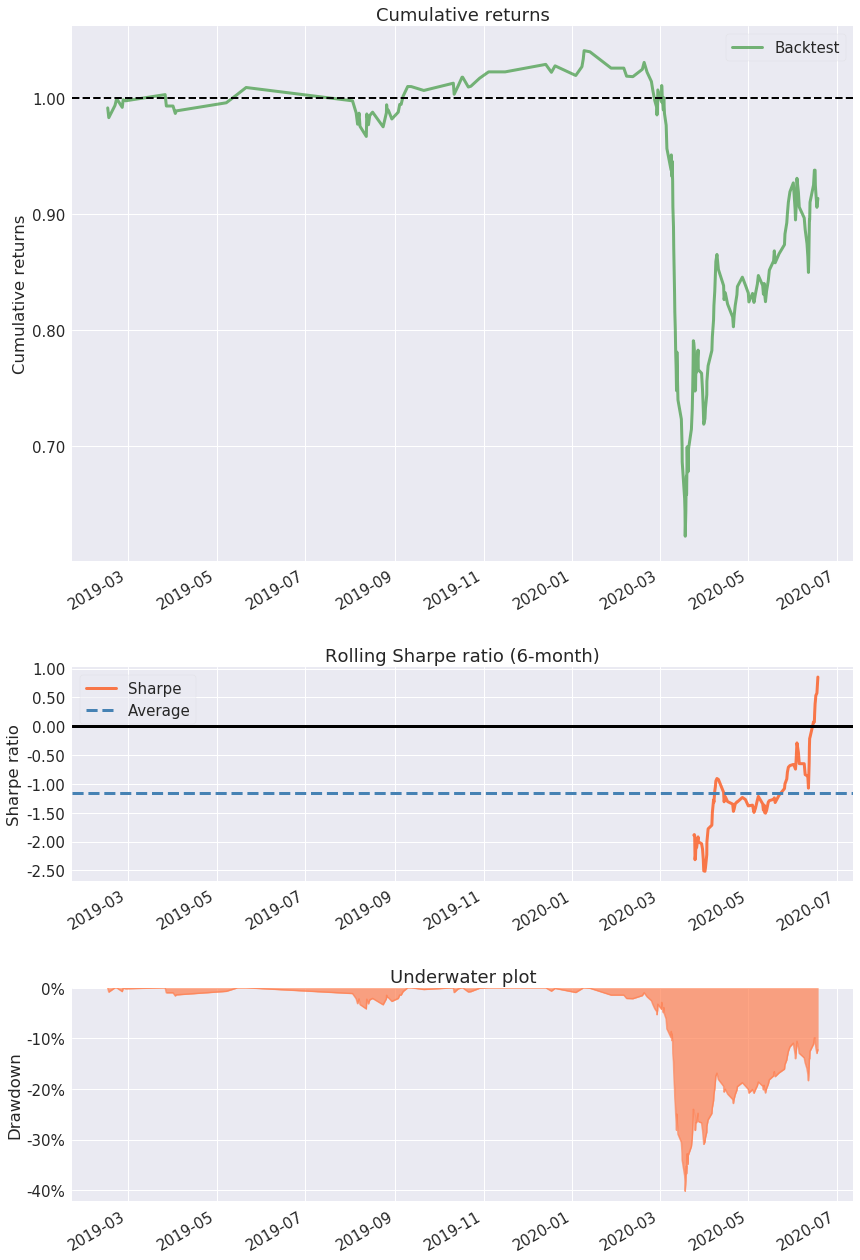

In [49]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### EUR/USD

In [50]:
ticker = 'EUR/USD'

In [51]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [52]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2018-08-23
End date,2020-06-17
Total months,8
,Backtest
Annual return,-3.6%
Cumulative returns,-2.7%
Annual volatility,10.5%
Sharpe ratio,-0.30
Calmar ratio,-0.34
Stability,0.22
Max drawdown,-10.8%


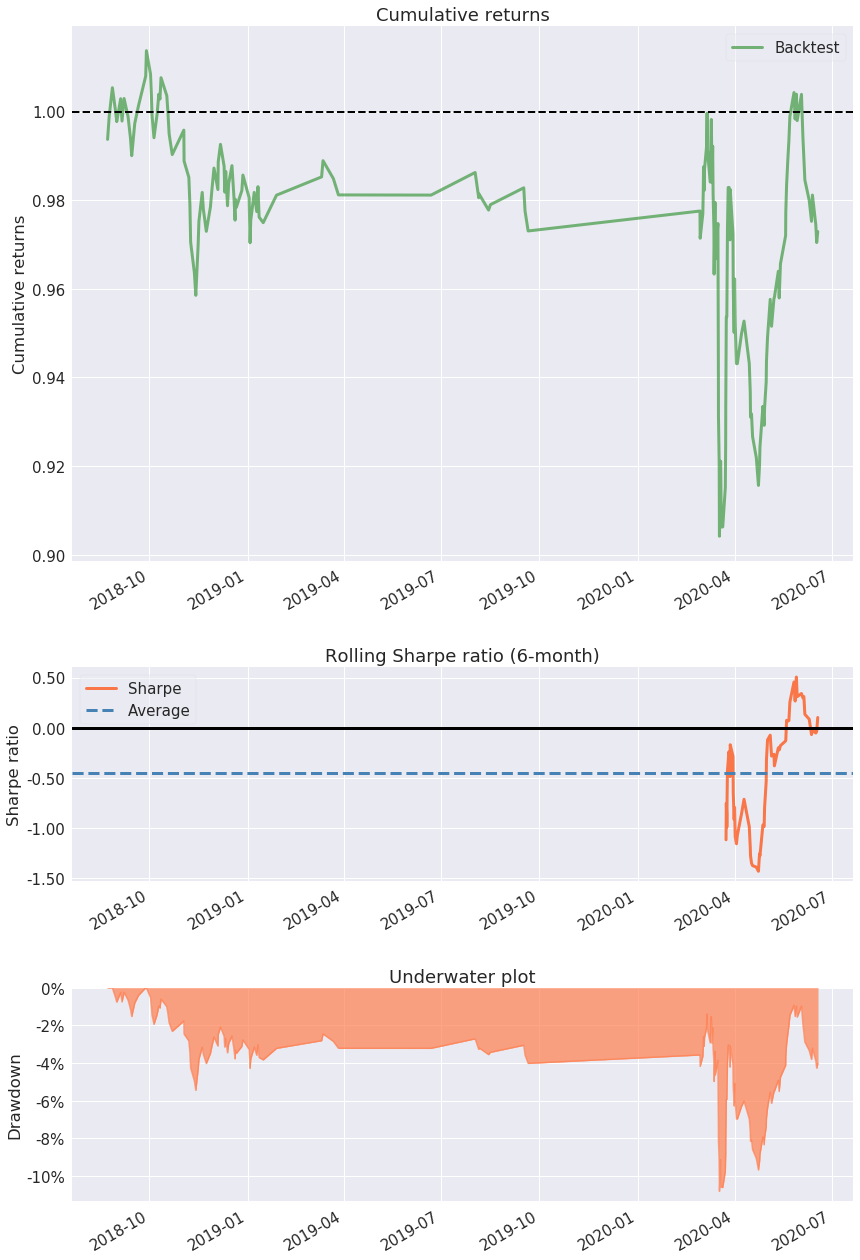

In [53]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2018-08-23
End date,2020-06-17
Total months,8
,Backtest
Annual return,5.2%
Cumulative returns,3.9%
Annual volatility,11.6%
Sharpe ratio,0.50
Calmar ratio,0.30
Stability,0.05
Max drawdown,-17.5%


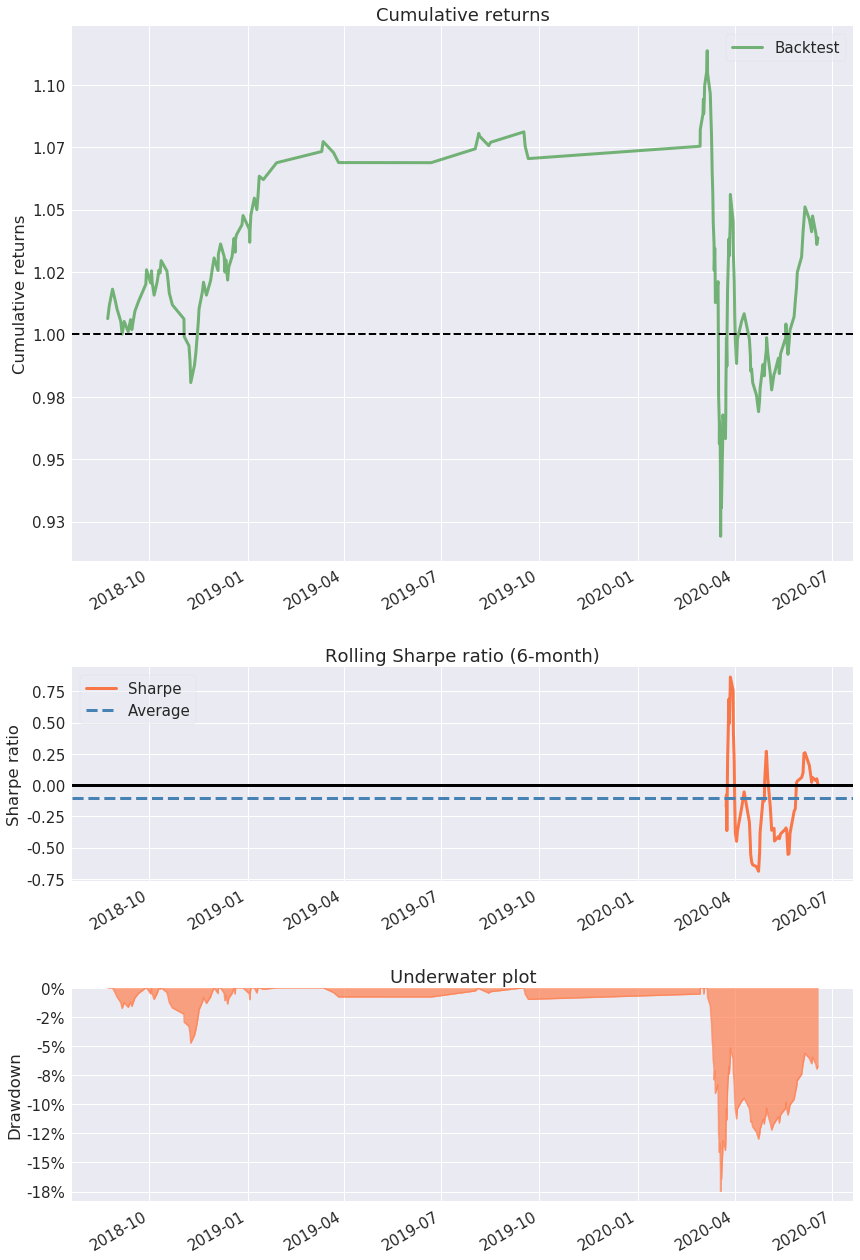

In [54]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### GBP/USD

In [56]:
ticker = 'GBP/USD'

In [57]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [58]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,18.5%
Cumulative returns,16.6%
Annual volatility,17.5%
Sharpe ratio,1.06
Calmar ratio,0.83
Stability,0.25
Max drawdown,-22.4%


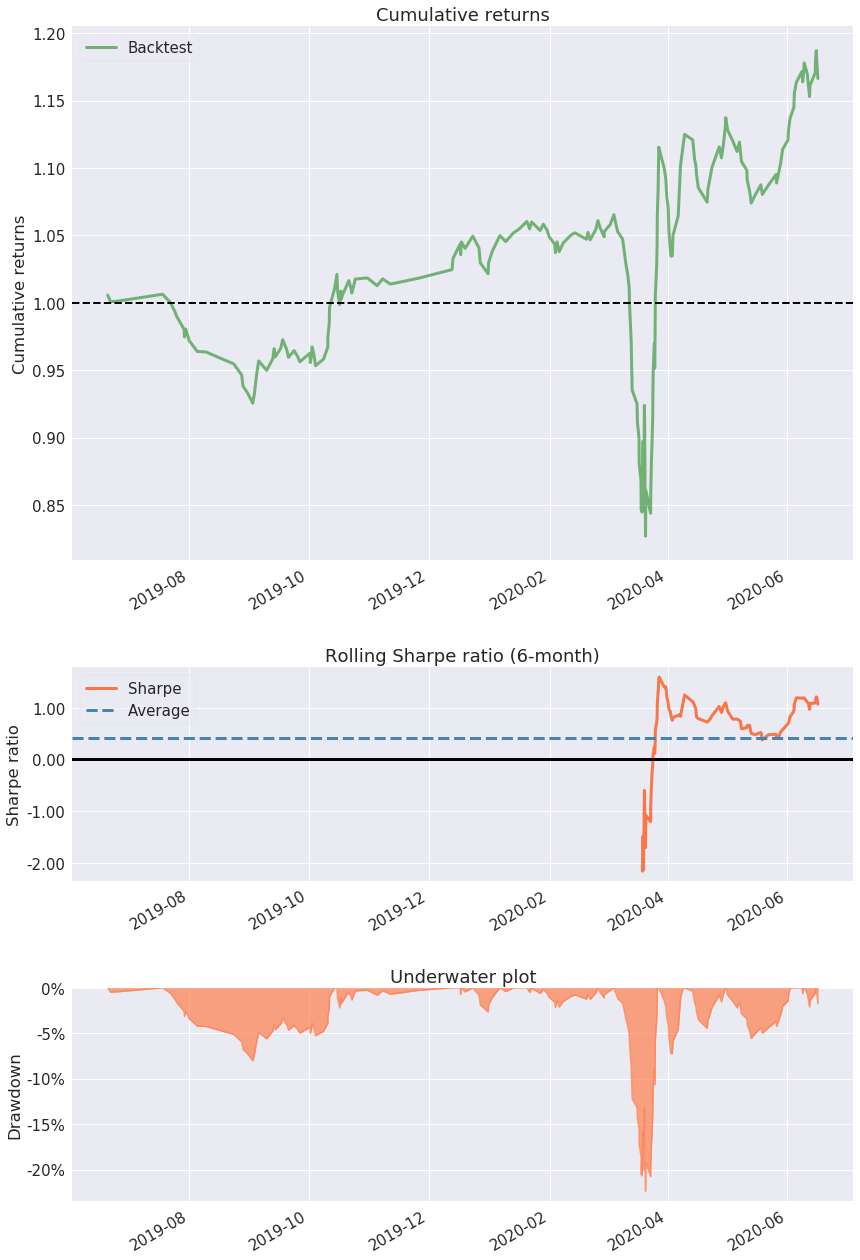

In [59]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,13.2%
Cumulative returns,11.9%
Annual volatility,13.5%
Sharpe ratio,0.99
Calmar ratio,0.77
Stability,0.17
Max drawdown,-17.2%


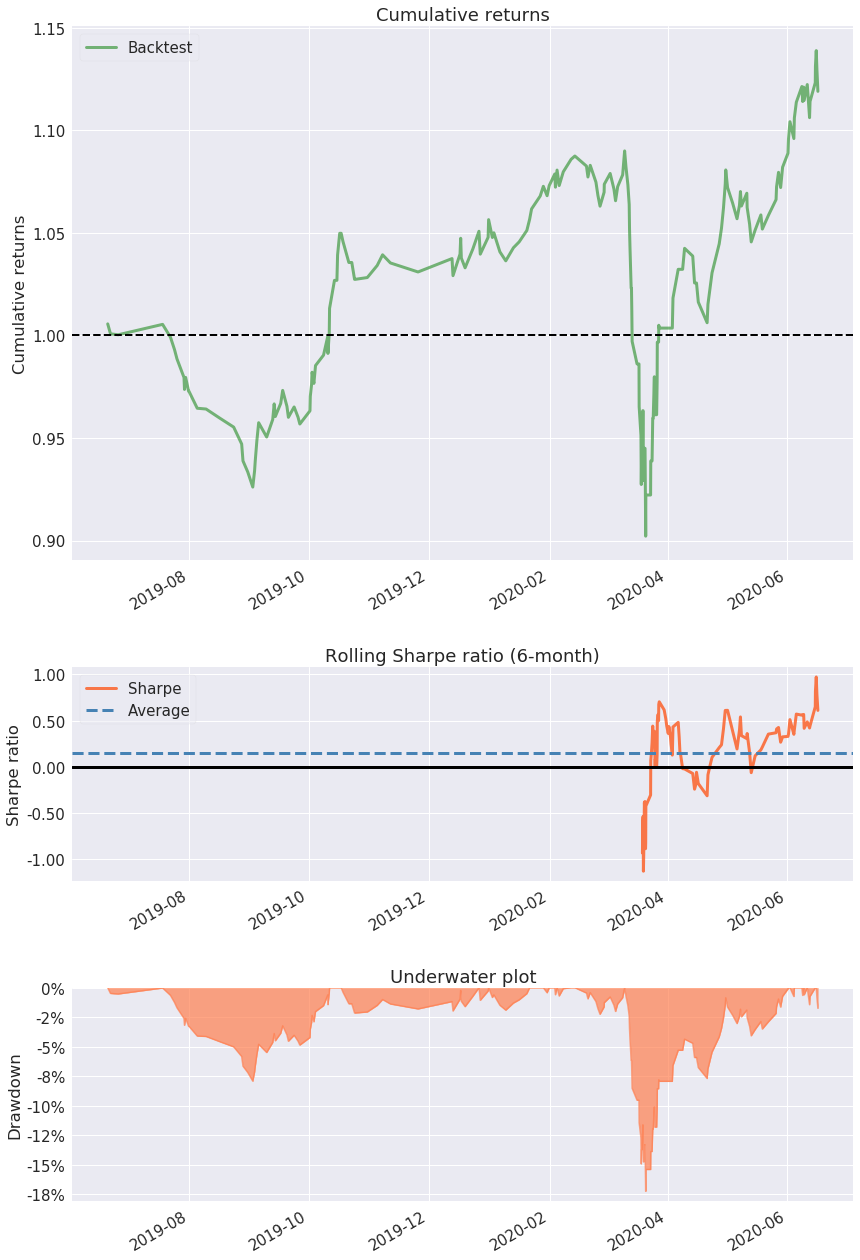

In [60]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### NZD/USD

In [61]:
ticker = 'NZD/USD'

In [62]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [63]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2019-01-21
End date,2020-06-17
Total months,10
,Backtest
Annual return,62.9%
Cumulative returns,50.5%
Annual volatility,16.5%
Sharpe ratio,3.05
Calmar ratio,5.24
Stability,0.78
Max drawdown,-12.0%


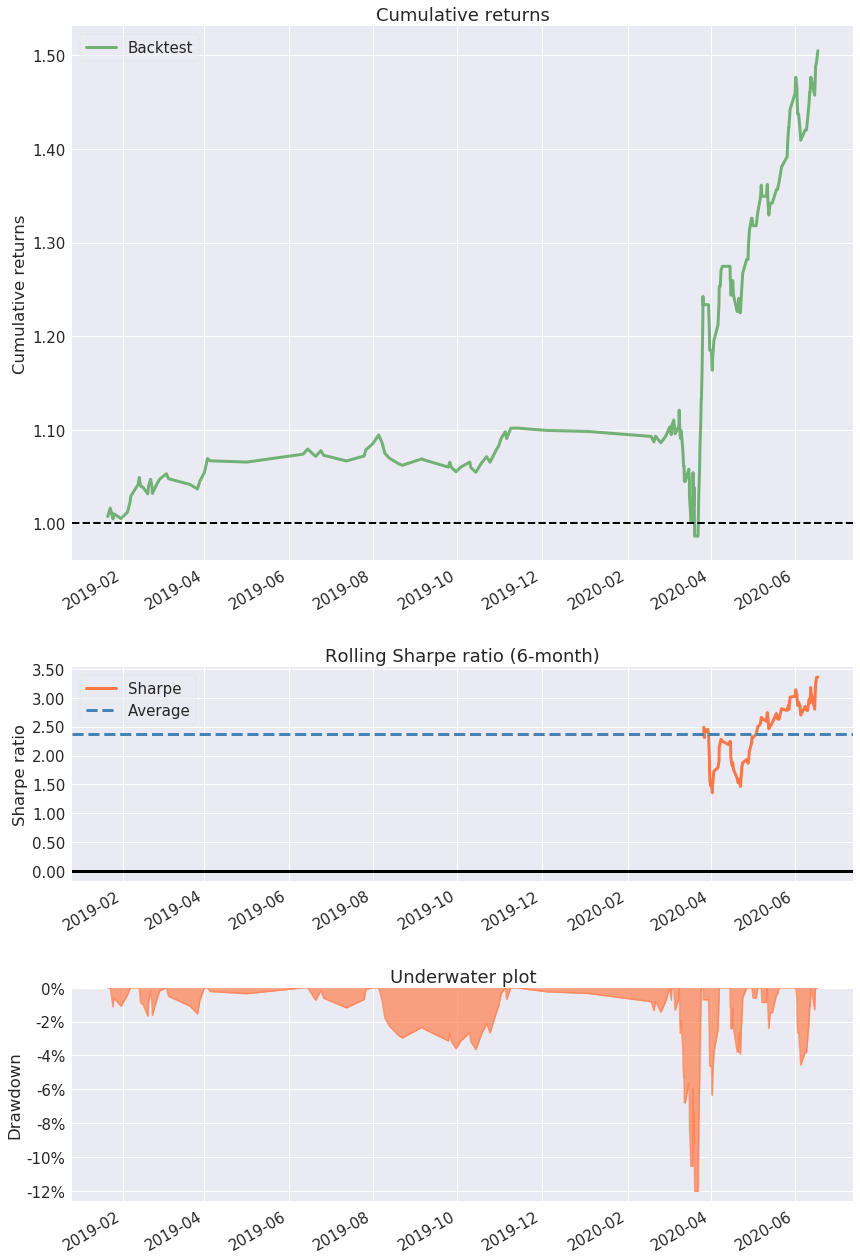

In [65]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2019-01-21
End date,2020-06-17
Total months,10
,Backtest
Annual return,10.2%
Cumulative returns,8.5%
Annual volatility,11.7%
Sharpe ratio,0.89
Calmar ratio,0.81
Stability,0.55
Max drawdown,-12.7%


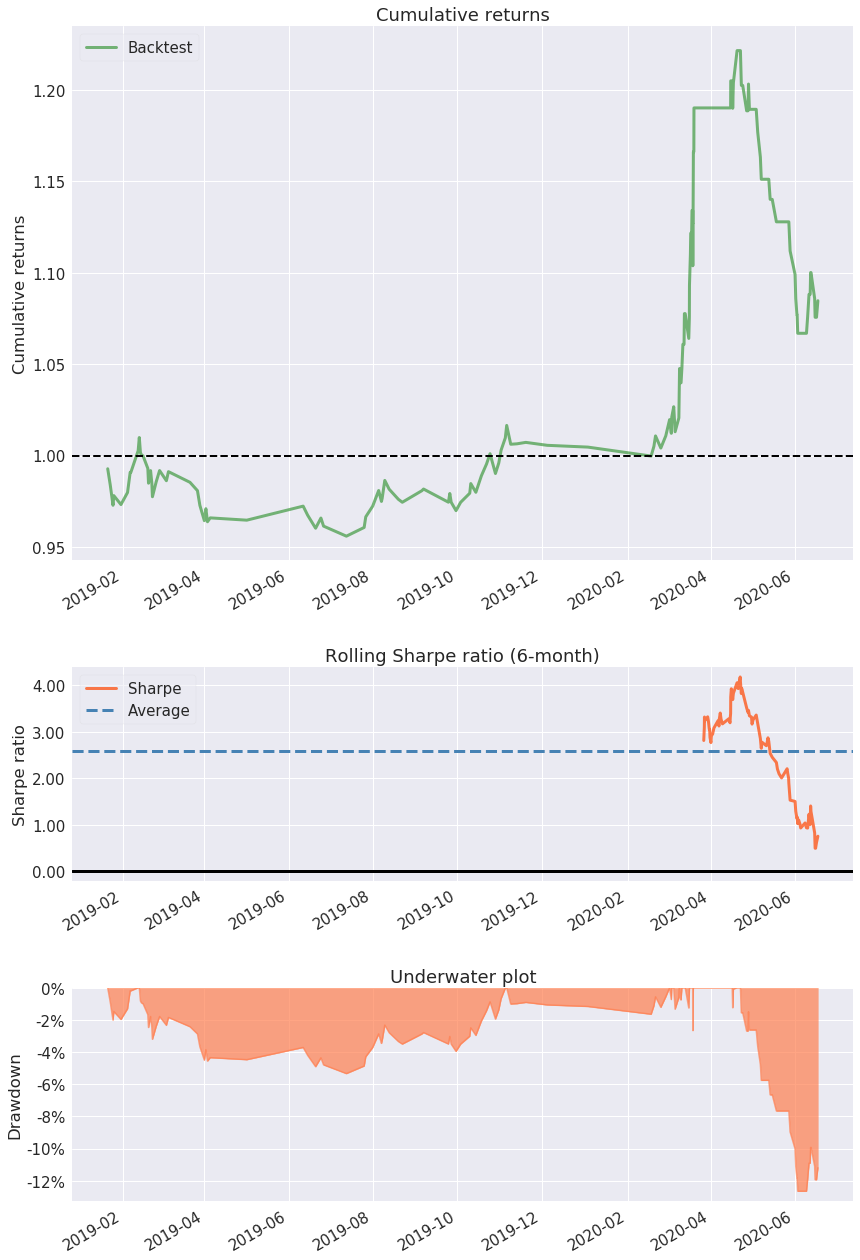

In [66]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### USD/CAD

In [67]:
ticker = 'USD/CAD'

In [68]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [69]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2018-09-04
End date,2020-06-16
Total months,10
,Backtest
Annual return,15.6%
Cumulative returns,12.9%
Annual volatility,11.4%
Sharpe ratio,1.33
Calmar ratio,1.13
Stability,0.38
Max drawdown,-13.8%


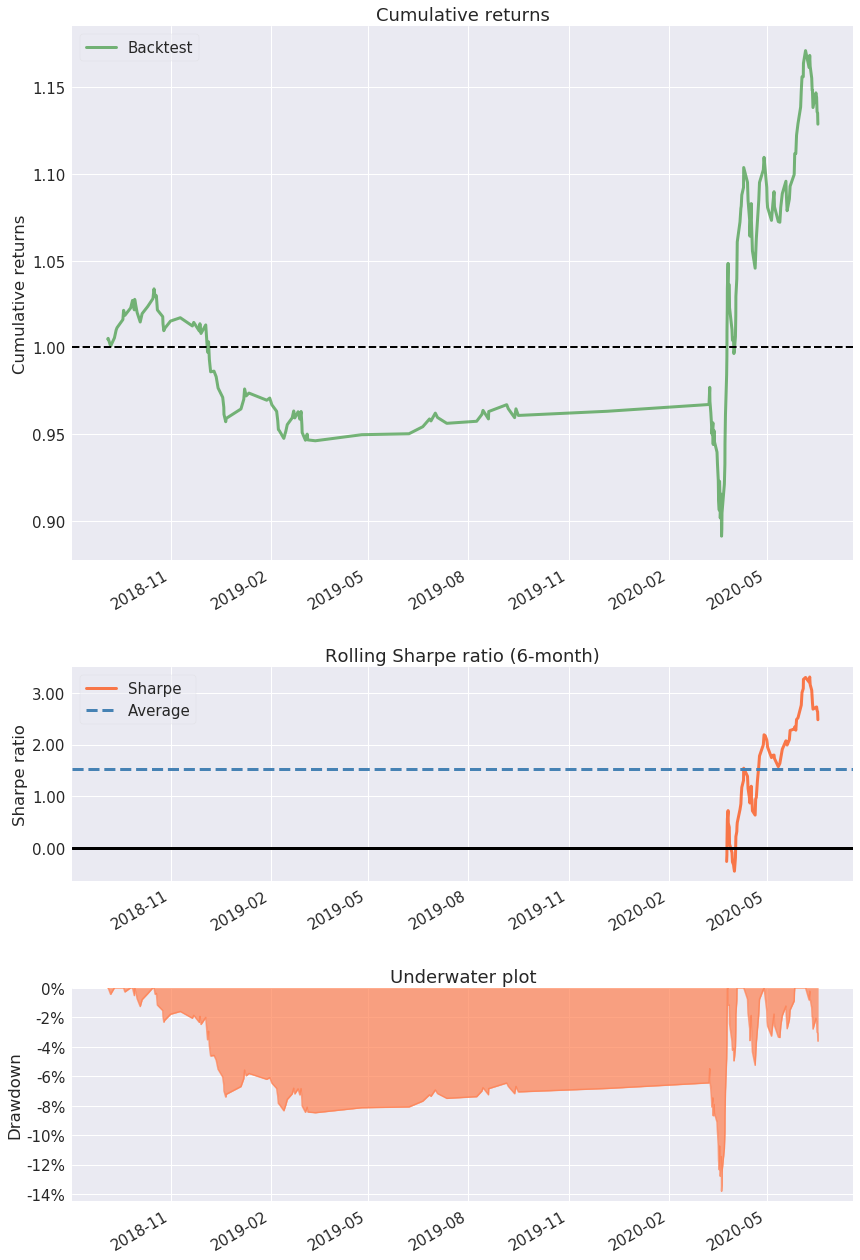

In [70]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2018-09-04
End date,2020-06-16
Total months,10
,Backtest
Annual return,1.8%
Cumulative returns,1.5%
Annual volatility,6.5%
Sharpe ratio,0.31
Calmar ratio,0.27
Stability,0.04
Max drawdown,-6.7%


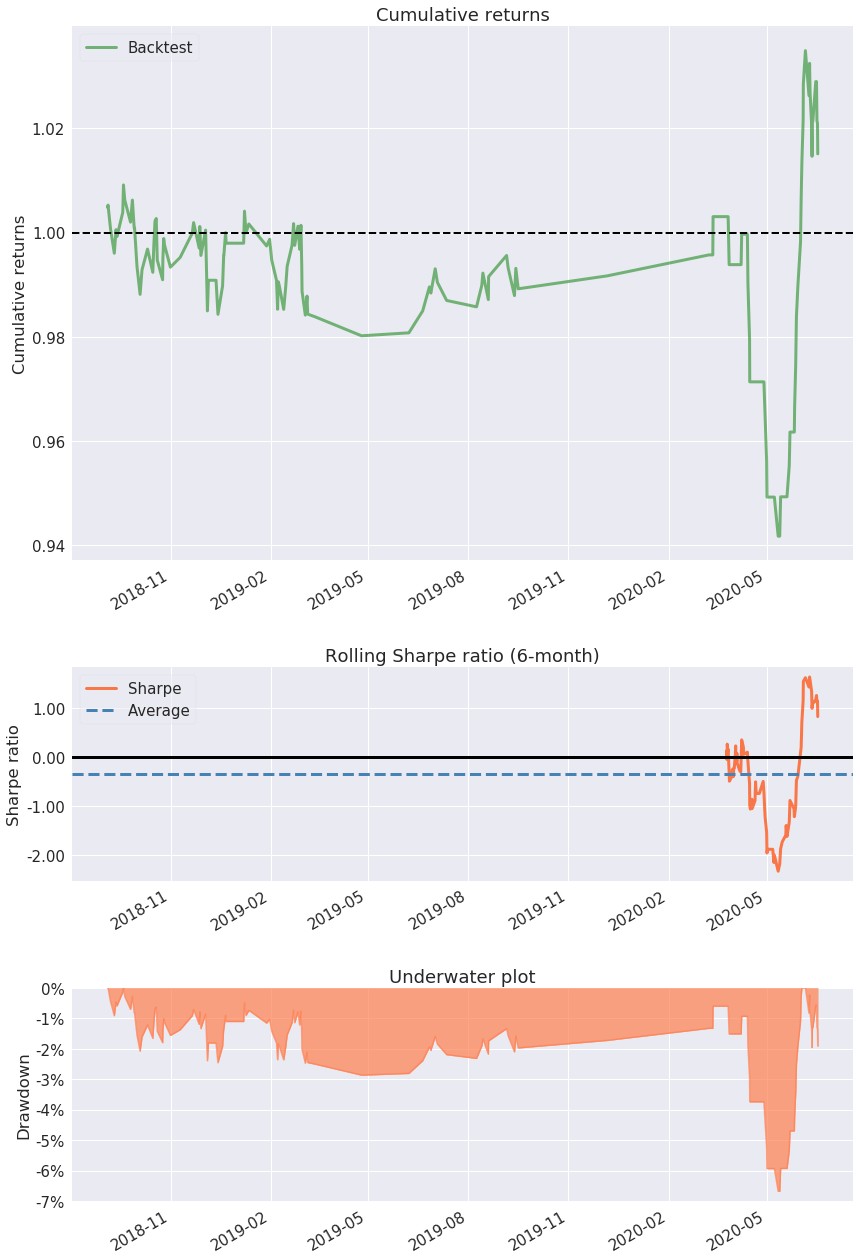

In [71]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### USD/JPY

In [72]:
ticker = 'USD/JPY'

In [73]:
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)

# Standardize data period across all currency pair for easy comparison
data = data.loc[min_period:max_period]
    
# splitting the data into training, validation and testing set.
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')

all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [74]:
RANDOM_STATE = 1
models = {
         'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
         'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                        random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
         'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
         'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }  

### Logistic regressions with 4 principal components

Start date,2018-02-15
End date,2020-06-17
Total months,9
,Backtest
Annual return,34.7%
Cumulative returns,25.8%
Annual volatility,14.6%
Sharpe ratio,2.12
Calmar ratio,3.13
Stability,0.53
Max drawdown,-11.1%


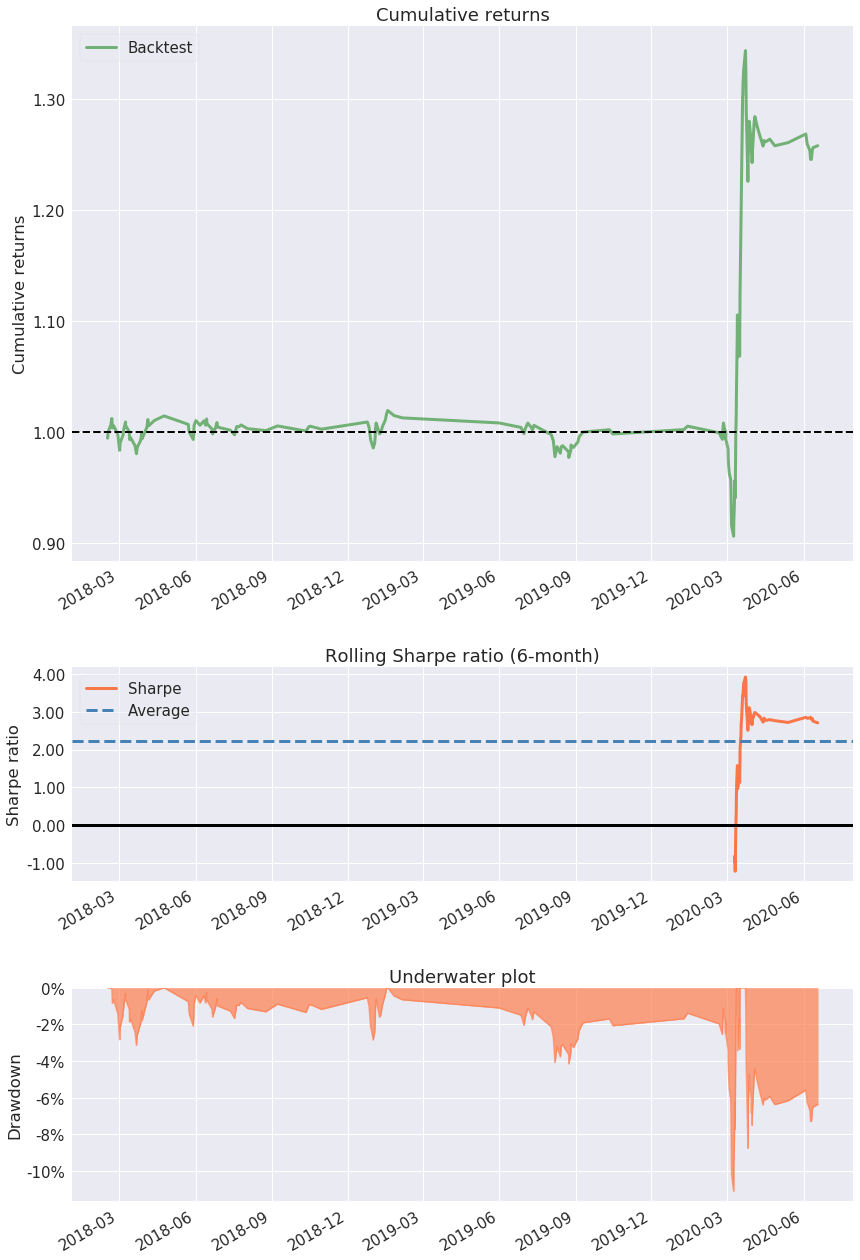

In [75]:
model = 'Scaler->PCA4->LogRegr'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Naive Bayes with 6 principal components

Start date,2018-02-15
End date,2020-06-17
Total months,9
,Backtest
Annual return,-3.6%
Cumulative returns,-2.8%
Annual volatility,9.1%
Sharpe ratio,-0.36
Calmar ratio,-0.34
Stability,0.06
Max drawdown,-10.6%


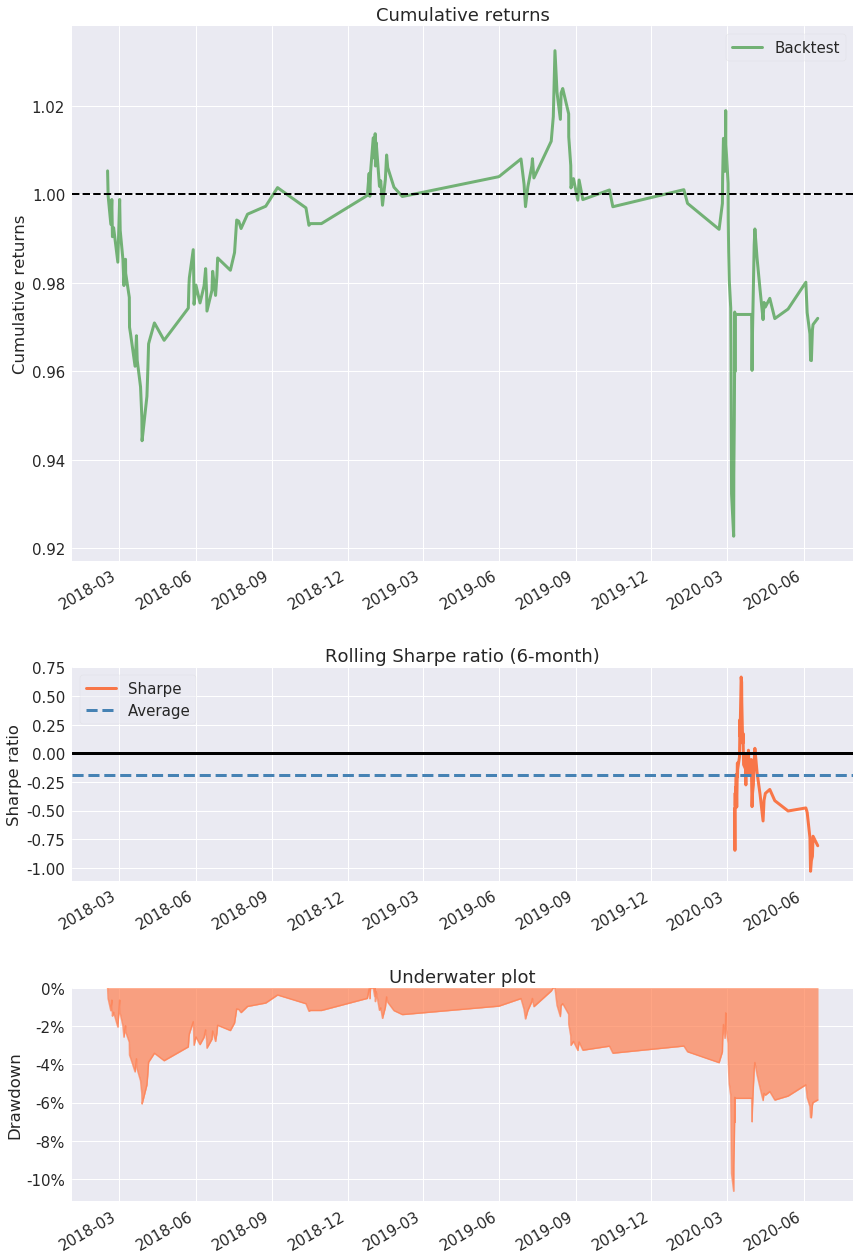

In [76]:
model = 'Scaler->PCA6->Naive Bayes'
cols = top_feat
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(models[model],X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

## Conclusion

To be added

###  <div style="text-align: right"> Appendix 1 - Buildeng 2nd level model </div>

In [45]:
ticker = 'AUD/USD'
data = pd.read_csv(os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv'), 
                   index_col=0, parse_dates=True)
# splitting the data   
X_train, Y_train, target_rtns_train \
, X_valid, Y_valid, target_rtns_valid \
, X_test, Y_test, target_rtns_test = wqu.train_valid_test_split(data,'50:25:25')
all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train)

In [46]:
cols = top_feat
vc = VotingClassifier(estimators=[('RF',models['RF']),
                                  ('ExtraTrees',models['ExtraTrees']),
                                  ('Scaler->PCA4->LogRegr', models['Scaler->PCA4->LogRegr']),
                                  ('Scaler->SVM',models['Scaler->PCA4->SVM'])],
                     voting = 'soft')

Start date,2017-06-02
End date,2019-01-04
Total months,11
,Backtest
Annual return,14.319%
Cumulative returns,13.412%
Annual volatility,10.023%
Sharpe ratio,1.39
Calmar ratio,2.40
Stability,0.81
Max drawdown,-5.954%


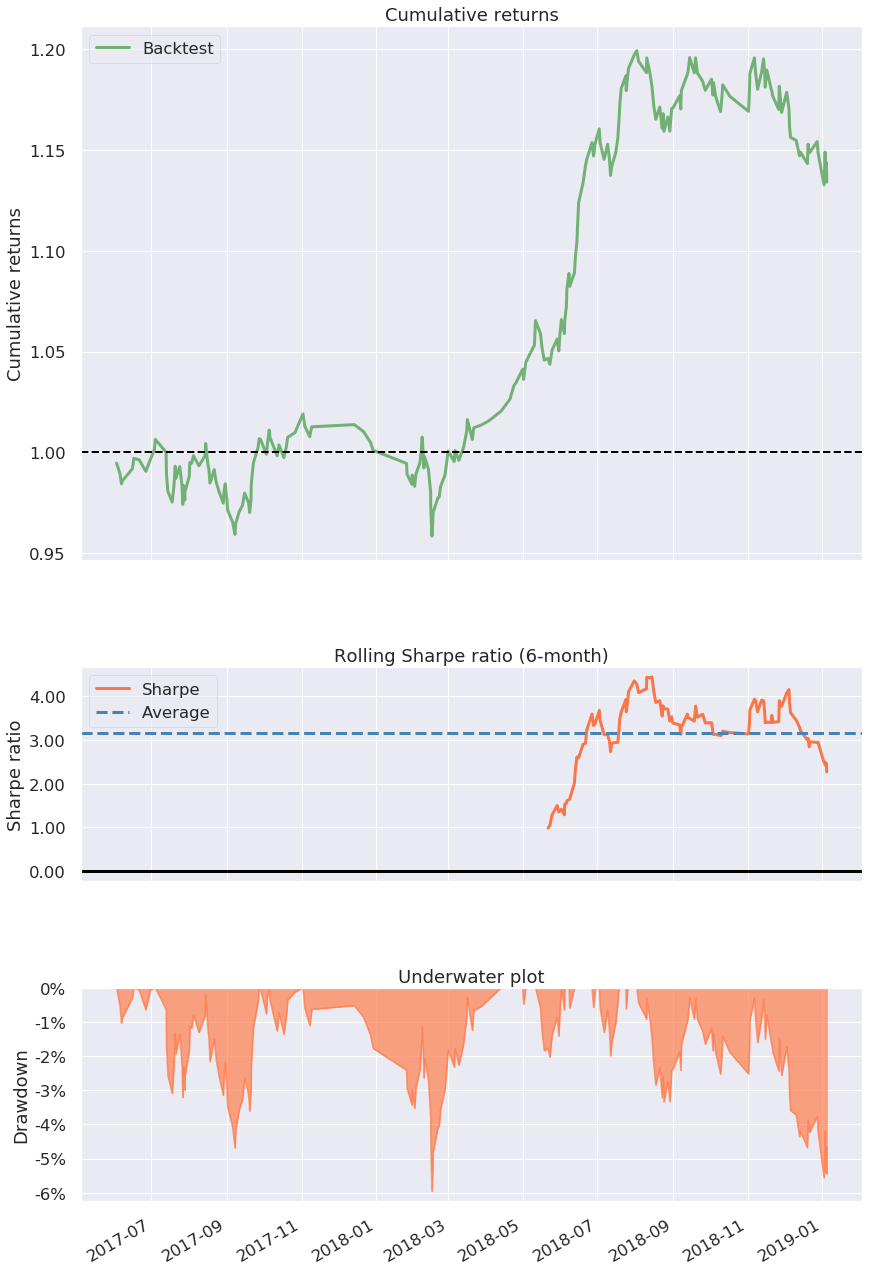

In [47]:
validation = True
if validation:
    wqu.get_pyfolio_simple_tear_sheet(vc,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(vc,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2019-01-11
End date,2020-06-19
Total months,11
,Backtest
Annual return,52.819%
Cumulative returns,49.01%
Annual volatility,21.989%
Sharpe ratio,2.04
Calmar ratio,1.75
Stability,0.54
Max drawdown,-30.252%


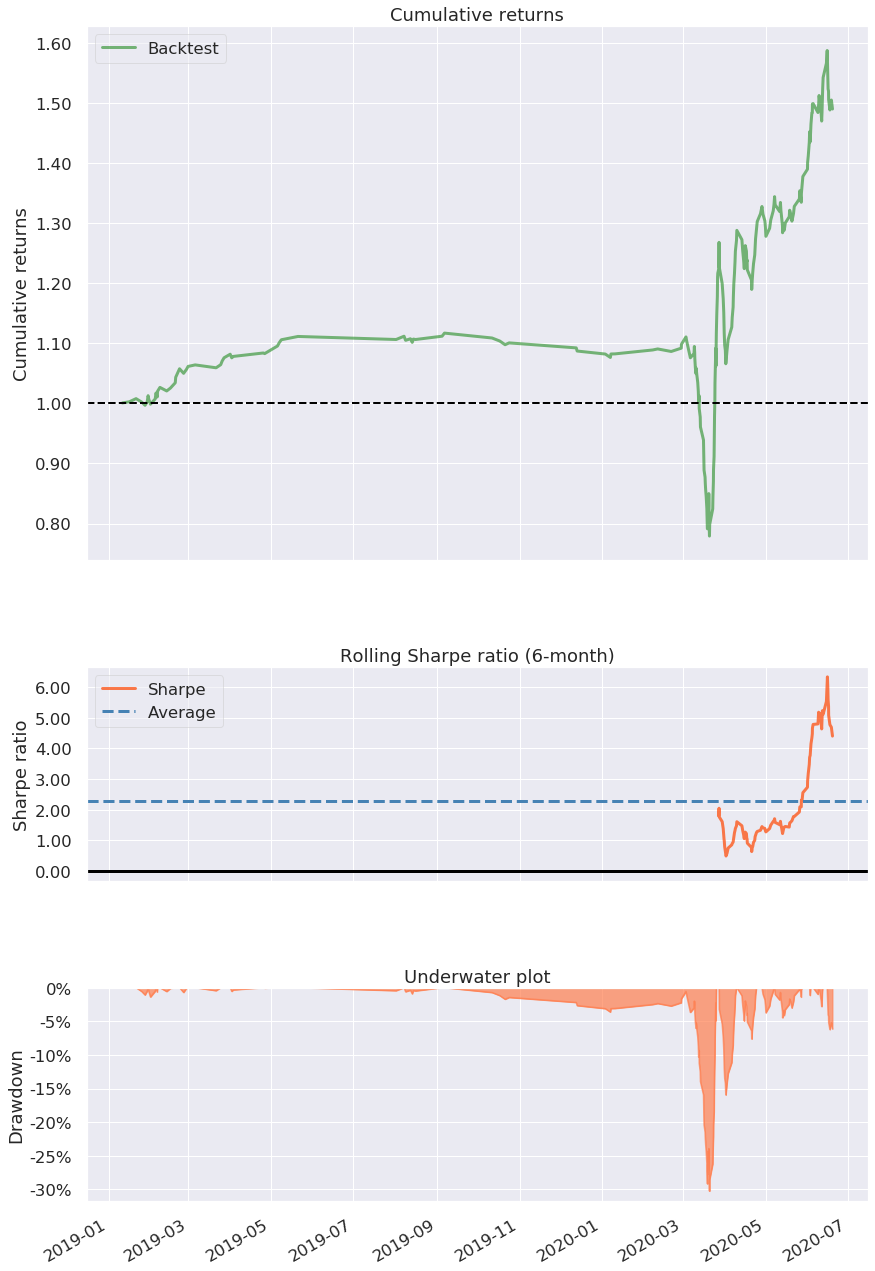

In [48]:
validation = False
if validation:
    wqu.get_pyfolio_simple_tear_sheet(vc,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    wqu.get_pyfolio_simple_tear_sheet(vc,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)